In [3]:
# import necessary packages
from zepid import load_sample_data, spline
from zepid.causal.doublyrobust import TMLE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
csv_path = './datasets/SEEREXport_11-14-2025.csv'
SeerData_df = pd.read_csv(csv_path)

/Users/deolubabs/Documents/python/ade_env/lib/python3.12/site-packages/zepid/datasets/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


# Preprocessing

In [4]:
# Create a copy of the dataframe to transform
SeerData_transform = SeerData_df.copy()

print(SeerData_transform.info())

#for col in SeerData_transform.select_dtypes(include=['object']).columns:
    #print(SeerData_transform[col].value_counts, "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4793660 entries, 0 to 4793659
Data columns (total 20 columns):
 #   Column                                           Dtype 
---  ------                                           ----- 
 0   Histologic Type ICD-O-3                          int64 
 1   Patient ID                                       int64 
 2   Age recode with <1 year olds and 90+             object
 3   Race recode (White, Black, Other)                object
 4   Sex                                              object
 5   Year of diagnosis                                int64 
 6   Median household income inflation adj to 2023    object
 7   Primary Site                                     int64 
 8   Tumor Size Over Time Recode (1988+)              object
 9   Time from diagnosis to treatment in days recode  object
 10  SEER cause-specific death classification         object
 11  Diagnostic Confirmation                          object
 12  Radiation recode            

In [5]:
# drop the unnecessary columns
SeerData_transform = SeerData_transform.drop(columns=[
    "Derived AJCC T, 7th ed (2010-2015)",
    "Derived AJCC N, 7th ed (2010-2015)",
    "Derived AJCC M, 7th ed (2010-2015)",
])

print(SeerData_transform.isna().sum())

Histologic Type ICD-O-3                            0
Patient ID                                         0
Age recode with <1 year olds and 90+               0
Race recode (White, Black, Other)                  0
Sex                                                0
Year of diagnosis                                  0
Median household income inflation adj to 2023      0
Primary Site                                       0
Tumor Size Over Time Recode (1988+)                0
Time from diagnosis to treatment in days recode    0
SEER cause-specific death classification           0
Diagnostic Confirmation                            0
Radiation recode                                   0
Chemotherapy recode (yes, no/unk)                  0
Survival months                                    0
First malignant primary indicator                  0
Vital status recode (study cutoff used)            0
dtype: int64


In [6]:
# Review data
SeerData_transform.head()

,Histologic Type ICD-O-3,Patient ID,Age recode with <1 year olds and 90+,"Race recode (White, Black, Other)",Sex,Year of diagnosis,Median household income inflation adj to 2023,Primary Site,Tumor Size Over Time Recode (1988+),Time from diagnosis to treatment in days recode,SEER cause-specific death classification,Diagnostic Confirmation,Radiation recode,"Chemotherapy recode (yes, no/unk)",Survival months,First malignant primary indicator,Vital status recode (study cutoff used)
0,8120,0,55-59 years,Black,Male,1981,Unknown/missing/no match/Not 1990-2023,674,Blank(s),Unable to calculate,Alive or dead of other cause,Positive histology,None/Unknown,No/Unknown,0136,Yes,Dead
1,8140,0,60-64 years,Black,Male,1985,Unknown/missing/no match/Not 1990-2023,341,Blank(s),Unable to calculate,Dead (attributable to this cancer dx),Positive histology,None/Unknown,No/Unknown,0084,No,Dead
2,8140,2,75-79 years,White,Female,1977,Unknown/missing/no match/Not 1990-2023,164,Blank(s),Unable to calculate,Alive or dead of other cause,Positive histology,None/Unknown,No/Unknown,0113,Yes,Dead
3,8720,4,70-74 years,White,Female,1984,Unknown/missing/no match/Not 1990-2023,447,Tumor Size Not Consistent Over Time or Not App...,Unable to calculate,Dead (attributable to this cancer dx),Positive histology,None/Unknown,No/Unknown,0025,No,Dead
4,8140,7,45-49 years,"Other (American Indian/AK Native, Asian/Pacifi...",Male,1992,"$90,000 - $94,999",343,050,071,Alive or dead of other cause,Positive histology,Beam radiation,No/Unknown,0147,Yes,Dead


In [7]:
# Remove the blank from the dataset: replace textual placeholders with NA
SeerData_transform = SeerData_transform.replace("Blank(s)", pd.NA)
print(SeerData_transform.isna().sum())


Histologic Type ICD-O-3                                 0
Patient ID                                              0
Age recode with <1 year olds and 90+                    0
Race recode (White, Black, Other)                       0
Sex                                                     0
Year of diagnosis                                       0
Median household income inflation adj to 2023           0
Primary Site                                            0
Tumor Size Over Time Recode (1988+)                713605
Time from diagnosis to treatment in days recode         0
SEER cause-specific death classification                0
Diagnostic Confirmation                                 0
Radiation recode                                        0
Chemotherapy recode (yes, no/unk)                       0
Survival months                                         0
First malignant primary indicator                       0
Vital status recode (study cutoff used)                 0
dtype: int64


In [8]:
# Rename the columns for easier access
SeerData_transform = SeerData_transform.rename(columns={
    "Histologic Type ICD-O-3": "histologic",
    "Patient ID": "patient_id",
    "Age recode with <1 year olds and 90+": "age_recode",
    "Race recode (White, Black, Other)": "race_cat",
    "Sex": "sex",
    "Year of diagnosis": "year_diagnosis",
    "Median household income inflation adj to 2023": "median_hh_income_2023",
    "Primary Site": "primary_site",
    "Tumor Size Over Time Recode (1988+)": "tumor_size_over_time",
    "Time from diagnosis to treatment in days recode": "time_diagnosis_treat_days",
    "SEER cause-specific death classification": "cause_specific_death",
    "Diagnostic Confirmation": "diagnosis_confirmation",
    "Radiation recode": "radiation",
    "Chemotherapy recode (yes, no/unk)": "chemo",
    "Survival months": "survival_months",
    "First malignant primary indicator": "first_malignant",
    "Vital status recode (study cutoff used)": "vital_status"
})

SeerData_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4793660 entries, 0 to 4793659
Data columns (total 17 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   histologic                 int64 
 1   patient_id                 int64 
 2   age_recode                 object
 3   race_cat                   object
 4   sex                        object
 5   year_diagnosis             int64 
 6   median_hh_income_2023      object
 7   primary_site               int64 
 8   tumor_size_over_time       object
 9   time_diagnosis_treat_days  object
 10  cause_specific_death       object
 11  diagnosis_confirmation     object
 12  radiation                  object
 13  chemo                      object
 14  survival_months            object
 15  first_malignant            object
 16  vital_status               object
dtypes: int64(4), object(13)
memory usage: 621.7+ MB


In [9]:
# Track memory usage of the dataframe
SeerData_transform.memory_usage(deep=True)

Index                              132
histologic                    38349280
patient_id                    38349280
age_recode                   287365222
race_cat                     279864888
sex                          258757384
year_diagnosis                38349280
median_hh_income_2023        336572178
primary_site                  38349280
tumor_size_over_time         378473912
time_diagnosis_treat_days    282918490
cause_specific_death         385537087
diagnosis_confirmation       332192365
radiation                    301090160
chemo                        274155866
survival_months              254250847
first_malignant              248540477
vital_status                 255672580
dtype: int64

# Confounders

In [10]:
confounders = [
    "age_recode", "race_cat", "sex", "primary_site", "first_malignant", "diagnosis_confirmation", 
    "median_hh_income_2023", "year_diagnosis", "tumor_size_over_time", "histologic"
]

SeerData_transform[confounders].head()

,age_recode,race_cat,sex,primary_site,first_malignant,diagnosis_confirmation,median_hh_income_2023,year_diagnosis,tumor_size_over_time,histologic
0,55-59 years,Black,Male,674,Yes,Positive histology,Unknown/missing/no match/Not 1990-2023,1981,<NA>,8120
1,60-64 years,Black,Male,341,No,Positive histology,Unknown/missing/no match/Not 1990-2023,1985,<NA>,8140
2,75-79 years,White,Female,164,Yes,Positive histology,Unknown/missing/no match/Not 1990-2023,1977,<NA>,8140
3,70-74 years,White,Female,447,No,Positive histology,Unknown/missing/no match/Not 1990-2023,1984,Tumor Size Not Consistent Over Time or Not App...,8720
4,45-49 years,"Other (American Indian/AK Native, Asian/Pacifi...",Male,343,Yes,Positive histology,"$90,000 - $94,999",1992,050,8140


In [11]:
print(SeerData_transform['chemo'].value_counts())

chemo
No/Unknown    3555078
Yes           1238582
Name: count, dtype: int64


In [12]:
# Creat a dictionary for columns containing categorical variables and their respective categories
'''
category_mappings = {
    'age_recode': [
        '00 years', '01-04 years', '05-09 years', '10-14 years',
        '15-19 years', '20-24 years', '25-29 years', '30-34 years',
        '35-39 years', '40-44 years', '45-49 years', '50-54 years',
        '55-59 years', '60-64 years', '65-69 years', '70-74 years',
        '75-79 years', '80-84 years', '85-89 years', '90+ years'
    ],
    'median_hh_income_2023': [
        '< $40,000', '$40,000 - $44,999', '$45,000 - $49,999', '$50,000 - $54,999',
        '$55,000 - $59,999', '$60,000 - $64,999', '$65,000 - $69,999', '$70,000 - $74,999',
        '$75,000 - $79,999', '$80,000 - $84,999', '$85,000 - $89,999', '$90,000 - $94,999',
        '$95,000 - $99,999', '$100,000 - $109,999', '$110,000 - $119,999', '$120,000+',
        'Unknown/missing/no match/Not 1990-2023'
    ]
}

#create a mapping dictionar for columns contraining two level categorical variables
two_factor_category = {
    'sex': {'Male': 0, 'Female': 1},
    'first_malignant': {'Yes': 1, 'No': 0}
}

# transform all the cofounder columns
for col in SeerData_transform:
    if col in category_mappings:
        SeerData_transform[col] = SeerData_transform[col].astype(pd.CategoricalDtype(categories=category_mappings[col], ordered=True)).cat.codes
    elif col in two_factor_category:
        SeerData_transform[col] = SeerData_transform[col].map(two_factor_category[col])
    elif col in ['primary_site', 'year_diagnosis', 'histologic', 'patient_id']:
        SeerData_transform[col] = SeerData_transform[col].astype('int32')

# Race, Diagnosis Confirmation, Tumor Size Over Time - One-Hot Encoding
race_dummies = pd.get_dummies(SeerData_transform['race_cat'], prefix='race')
diagnosis_dummies = pd.get_dummies(SeerData_transform['diagnosis_confirmation'])
tumor_size_dummies = pd.get_dummies(SeerData_transform['tumor_size_over_time'])

# Concatenate the new dummy variables to the original dataframe
SeerData_transform = pd.concat([SeerData_transform, race_dummies, diagnosis_dummies, tumor_size_dummies], axis=1)


confounders_new = [
    "age_recode_new", "race_cat_new", "sex_new", "primary_site_new", "first_malignant_new", "diagnosis_confirmation_new", 
    "median_hh_income_2023_new", "year_diagnosis_new", "tumor_size_over_time_new", "histologic_new"
]

#SeerData_transform[confounders_new].head()

print(SeerData_transform.head())

'''

'\ncategory_mappings = {\n    \'age_recode\': [\n        \'00 years\', \'01-04 years\', \'05-09 years\', \'10-14 years\',\n        \'15-19 years\', \'20-24 years\', \'25-29 years\', \'30-34 years\',\n        \'35-39 years\', \'40-44 years\', \'45-49 years\', \'50-54 years\',\n        \'55-59 years\', \'60-64 years\', \'65-69 years\', \'70-74 years\',\n        \'75-79 years\', \'80-84 years\', \'85-89 years\', \'90+ years\'\n    ],\n    \'median_hh_income_2023\': [\n        \'< $40,000\', \'$40,000 - $44,999\', \'$45,000 - $49,999\', \'$50,000 - $54,999\',\n        \'$55,000 - $59,999\', \'$60,000 - $64,999\', \'$65,000 - $69,999\', \'$70,000 - $74,999\',\n        \'$75,000 - $79,999\', \'$80,000 - $84,999\', \'$85,000 - $89,999\', \'$90,000 - $94,999\',\n        \'$95,000 - $99,999\', \'$100,000 - $109,999\', \'$110,000 - $119,999\', \'$120,000+\',\n        \'Unknown/missing/no match/Not 1990-2023\'\n    ]\n}\n\n#create a mapping dictionar for columns contraining two level categorical 

# EDA

In [13]:
SeerData_EDA = SeerData_transform.copy()

SeerData_EDA.head()
len(SeerData_EDA)

4793660

In [14]:
print(SeerData_EDA.nunique())

histologic                       705
patient_id                   4177366
age_recode                        20
race_cat                           4
sex                                2
year_diagnosis                    48
median_hh_income_2023             17
primary_site                     330
tumor_size_over_time             362
time_diagnosis_treat_days        733
cause_specific_death               3
diagnosis_confirmation             9
radiation                          9
chemo                              2
survival_months                  577
first_malignant                    2
vital_status                       2
dtype: int64


In [15]:
# Remove the duplicate columns based on patient_id
SeerData_EDA_unique = SeerData_EDA.drop_duplicates(subset=['patient_id'])

print(SeerData_EDA_unique.nunique(), '\n')
print(len(SeerData_EDA_unique))

histologic                       699
patient_id                   4177366
age_recode                        20
race_cat                           4
sex                                2
year_diagnosis                    48
median_hh_income_2023             17
primary_site                     330
tumor_size_over_time             359
time_diagnosis_treat_days        733
cause_specific_death               3
diagnosis_confirmation             9
radiation                          9
chemo                              2
survival_months                  577
first_malignant                    2
vital_status                       2
dtype: int64 

4177366


In [16]:
for col in SeerData_EDA_unique.columns:
    if SeerData_EDA_unique[col].dtype == 'object':
        value_counts = SeerData_EDA_unique[col].value_counts()
        unknown_indicators = ['Unknown', 'Blank(s)', 'UNK', 'Not stated', '999', '9999']
        for indicator in unknown_indicators:
            if indicator in value_counts:
                print(f"'{col}' contains unknown indicator: '{indicator}'")

'race_cat' contains unknown indicator: 'Unknown'
'diagnosis_confirmation' contains unknown indicator: 'Unknown'
'survival_months' contains unknown indicator: 'Unknown'


In [17]:
# Replace the unknown indicators with NaN
unknown_indicators = ['Unknown', 'Blank(s)', 'UNK', 'Not stated', '999', '9999']
SeerData_EDA_unique = SeerData_EDA_unique.replace(unknown_indicators, pd.NA)

print(SeerData_EDA_unique.isna().sum())

histologic                        0
patient_id                        0
age_recode                        0
race_cat                      27728
sex                               0
year_diagnosis                    0
median_hh_income_2023             0
primary_site                      0
tumor_size_over_time         668710
time_diagnosis_treat_days         0
cause_specific_death              0
diagnosis_confirmation        70638
radiation                         0
chemo                             0
survival_months               55470
first_malignant                   0
vital_status                      0
dtype: int64


In [18]:
# Drop records with missing values in key columns
SeerData_EDA_clean = SeerData_EDA_unique.dropna()

print(SeerData_EDA_clean.isna().sum())

print(SeerData_EDA_clean.shape)

histologic                   0
patient_id                   0
age_recode                   0
race_cat                     0
sex                          0
year_diagnosis               0
median_hh_income_2023        0
primary_site                 0
tumor_size_over_time         0
time_diagnosis_treat_days    0
cause_specific_death         0
diagnosis_confirmation       0
radiation                    0
chemo                        0
survival_months              0
first_malignant              0
vital_status                 0
dtype: int64
(3414184, 17)


## Feature Understanding
(Univariate analysis)

- Histogram
- KDE
- Boxplot

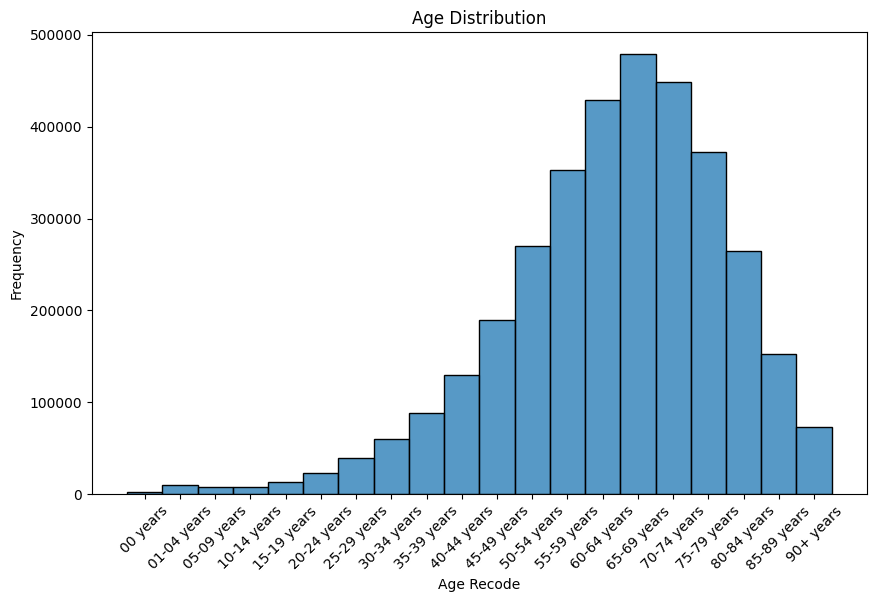

In [19]:
# Age Distribution (Demographyphic Feature Understanding)
plt.figure(figsize=(10, 6))
sns.histplot(SeerData_EDA_clean['age_recode'].sort_values(), bins=20)
plt.title('Age Distribution')
plt.xlabel('Age Recode')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show() 


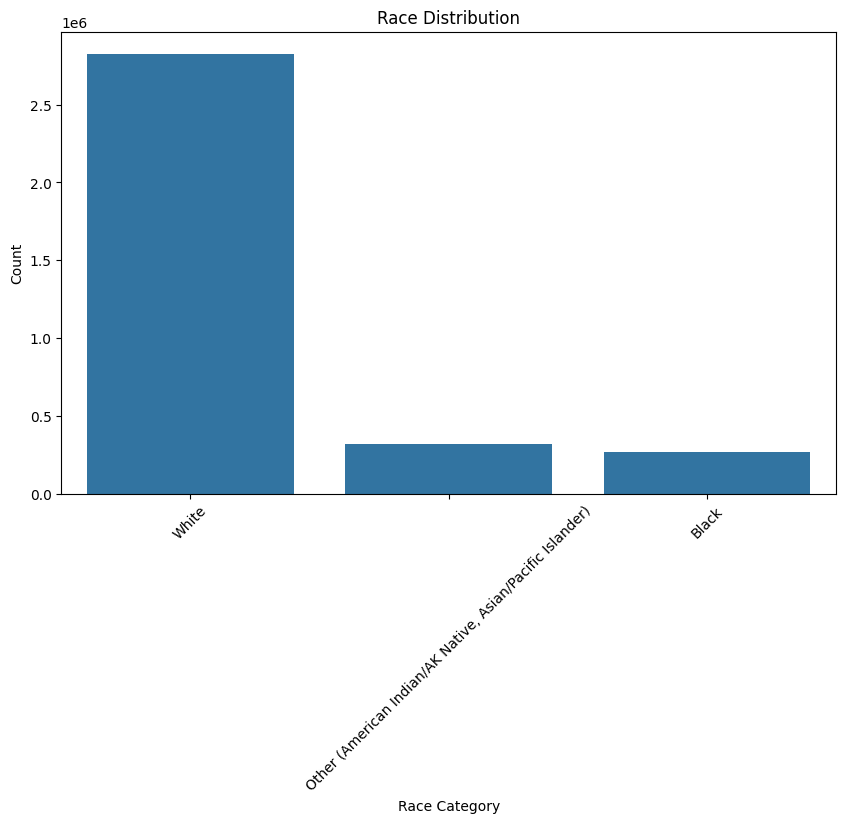

In [20]:
# Race Distribution (Demographyphic Feature Understanding)
plt.figure(figsize=(10, 6))
sns.countplot(data=SeerData_EDA_clean, x='race_cat')
plt.title('Race Distribution')
plt.xlabel('Race Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

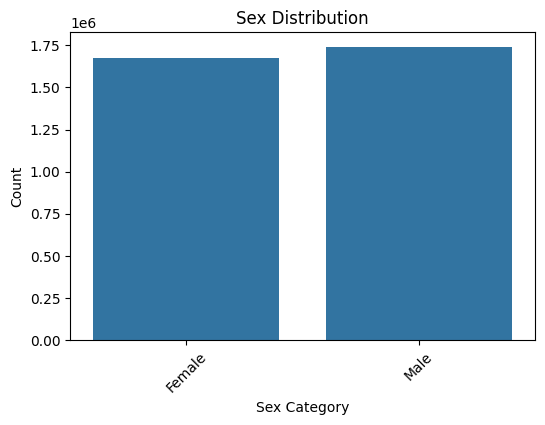

In [21]:
# Sex Distribution (Demographyphic Feature Understanding)
plt.figure(figsize=(6, 4))
sns.countplot(data=SeerData_EDA_clean   , x='sex')
plt.title('Sex Distribution')
plt.xlabel('Sex Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

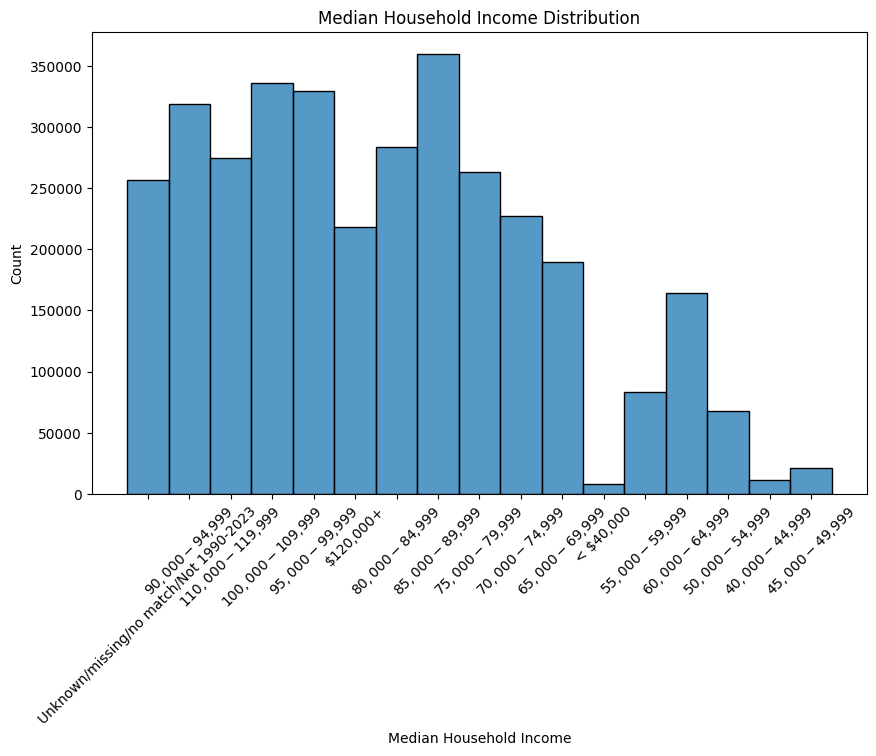

In [22]:
# Median Household Income Distribution (Demographyphic Feature Understanding)
plt.figure(figsize=(10, 6))
sns.histplot(SeerData_EDA_clean['median_hh_income_2023'], bins=20)
plt.title('Median Household Income Distribution')
plt.xlabel('Median Household Income')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

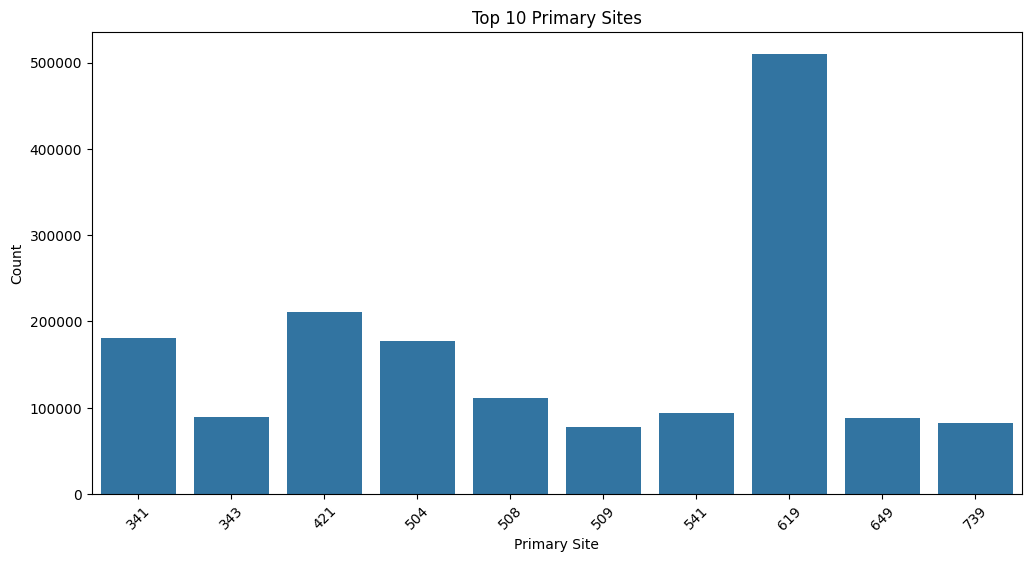

In [23]:
# Top 10 Primary Sites of the Cancer
primary_site_counts = SeerData_EDA_clean['primary_site'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=primary_site_counts.index, y=primary_site_counts.values)
plt.title('Top 10 Primary Sites')
plt.xlabel('Primary Site')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

histologic
8140    1000787
8500     390958
8070     184120
8010      95252
8130      94790
Name: count, dtype: int64


/var/folders/yp/95yw5ngj7dj323g4w6jw0ds80000gn/T/ipykernel_21272/353627522.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SeerData_EDA_clean['histologic_desc'] = SeerData_EDA_clean['histologic'].map(histology_map)


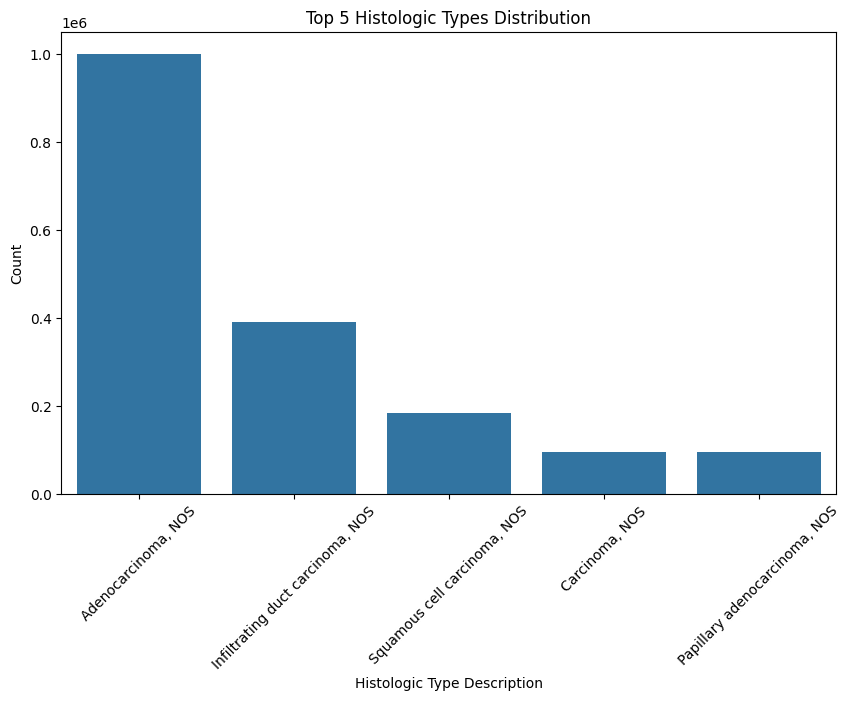

In [24]:
# Histologic Type Distribution (Cancer Type)

histologic_distribution = SeerData_EDA_clean['histologic'].value_counts().nlargest()
print(histologic_distribution)
'''

plt.figure(figsize=(12, 6))
sns.histplot(histologic_distribution)
plt.title('Histologic Type Distribution')
plt.xlabel('Histologic Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
'''

histology_map = {
    8140: 'Adenocarcinoma, NOS',
    8500: 'Infiltrating duct carcinoma, NOS',
    8070: 'Squamous cell carcinoma, NOS',
    8010: 'Carcinoma, NOS',
    8130: 'Papillary adenocarcinoma, NOS'
}

SeerData_EDA_clean['histologic_desc'] = SeerData_EDA_clean['histologic'].map(histology_map)
plt.figure(figsize=(10, 6))
sns.countplot(data=SeerData_EDA_clean, x='histologic_desc', order=SeerData_EDA_clean['histologic_desc'].value_counts().index)
plt.title('Top 5 Histologic Types Distribution')
plt.xlabel('Histologic Type Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



In [25]:
SeerData_EDA_clean.head()

#print(SeerData_EDA_clean['survival_months'].value_counts())

,histologic,patient_id,age_recode,race_cat,sex,year_diagnosis,median_hh_income_2023,primary_site,tumor_size_over_time,time_diagnosis_treat_days,cause_specific_death,diagnosis_confirmation,radiation,chemo,survival_months,first_malignant,vital_status,histologic_desc
3,8720,4,70-74 years,White,Female,1984,Unknown/missing/no match/Not 1990-2023,447,Tumor Size Not Consistent Over Time or Not App...,Unable to calculate,Dead (attributable to this cancer dx),Positive histology,None/Unknown,No/Unknown,0025,No,Dead,NaN
4,8140,7,45-49 years,"Other (American Indian/AK Native, Asian/Pacifi...",Male,1992,"$90,000 - $94,999",343,050,071,Alive or dead of other cause,Positive histology,Beam radiation,No/Unknown,0147,Yes,Dead,"Adenocarcinoma, NOS"
6,9823,11,60-64 years,White,Female,1991,"$90,000 - $94,999",421,Tumor Size Not Consistent Over Time or Not App...,Unable to calculate,Alive or dead of other cause,Positive histology,None/Unknown,No/Unknown,0094,Yes,Dead,NaN
7,9440,14,25-29 years,White,Male,1989,Unknown/missing/no match/Not 1990-2023,711,Unknown or size unreasonable (includes any tum...,027,Dead (attributable to this cancer dx),Positive histology,Beam radiation,Yes,0029,Yes,Dead,NaN
9,9061,18,40-44 years,White,Male,2002,"$110,000 - $119,999",629,043,000,Alive or dead of other cause,Positive histology,Beam radiation,No/Unknown,0244,No,Alive,NaN


## Feature Relationships
- Scatterplots
- Correlation Matrix
- Pairplots
- Groupby comparisons

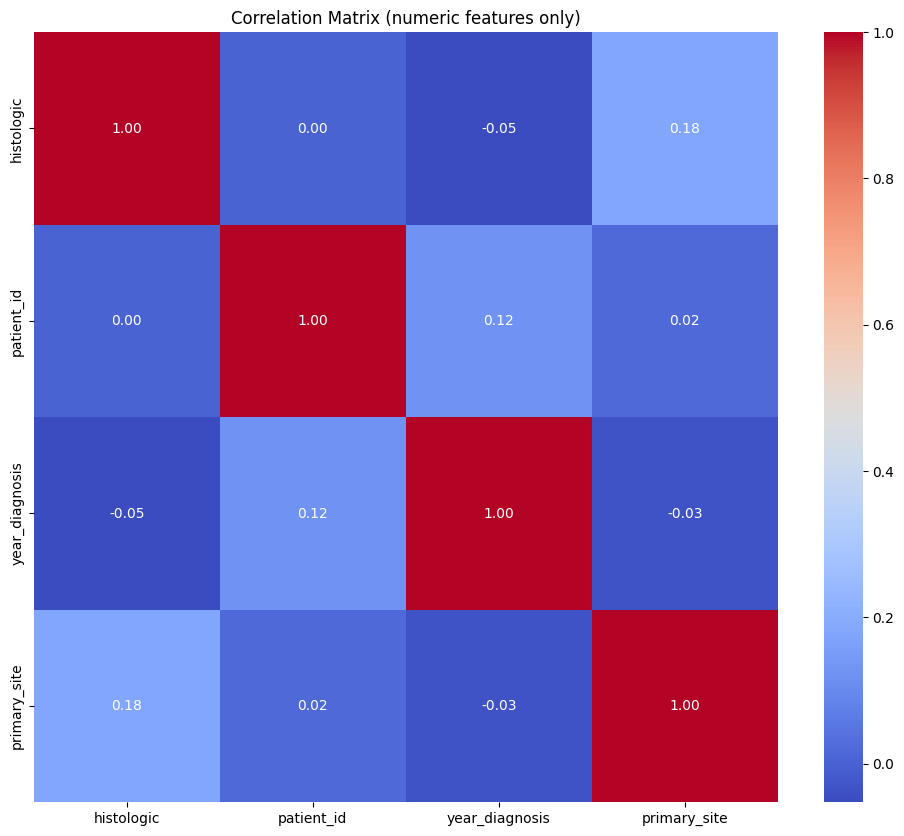

In [26]:
# Correlation Matrix (use only numeric columns to avoid conversion errors from non-numeric strings)
numeric_df = SeerData_EDA_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (numeric features only)')
plt.show()

radiation   Beam radiation  Combination of beam with implants or isotopes  \
chemo                                                                       
No/Unknown          467331                                          33876   
Yes                 394347                                           8771   

radiation   None/Unknown  Other than beam radiation (1973-1987 cases only)  \
chemo                                                                        
No/Unknown       1779999                                                59   
Yes               567057                                                22   

radiation   Radiation, NOS  method or source not specified  \
chemo                                                        
No/Unknown                                            4016   
Yes                                                   3867   

radiation   Radioactive implants (includes brachytherapy) (1988+)  \
chemo                                                       

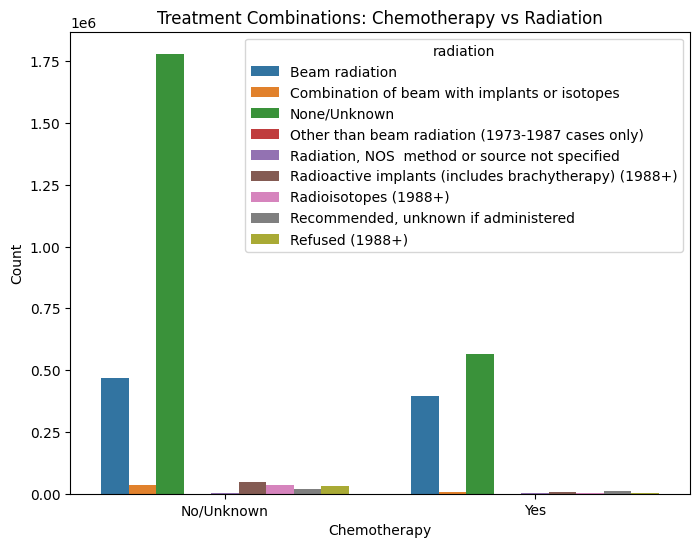

In [27]:
# Treatment Combinations: Chemotherapy vs Radiation
treatment_combo = pd.crosstab(SeerData_EDA_clean['chemo'], SeerData_EDA_clean['radiation'])
print(treatment_combo)

treatment_counts = SeerData_EDA_clean.groupby(['chemo', 'radiation']).size().reset_index(name='counts')

plt.figure(figsize=(8, 6))
sns.barplot(data=treatment_counts, x='chemo', y='counts', hue='radiation')
plt.title('Treatment Combinations: Chemotherapy vs Radiation')
plt.xlabel('Chemotherapy')
plt.ylabel('Count')
plt.show()

chemo        No/Unknown    Yes
age_recode                    
00 years          37.58  62.42
01-04 years       19.07  80.93
05-09 years       26.22  73.78
10-14 years       34.66  65.34
15-19 years       46.61  53.39
20-24 years       59.20  40.80
25-29 years       63.99  36.01
30-34 years       62.75  37.25
35-39 years       59.46  40.54
40-44 years       57.90  42.10
45-49 years       58.37  41.63
50-54 years       62.65  37.35
55-59 years       65.79  34.21
60-64 years       68.80  31.20
65-69 years       72.16  27.84
70-74 years       74.84  25.16
75-79 years       77.98  22.02
80-84 years       83.01  16.99
85-89 years       88.48  11.52
90+ years         94.10   5.90


<Figure size 1000x600 with 0 Axes>

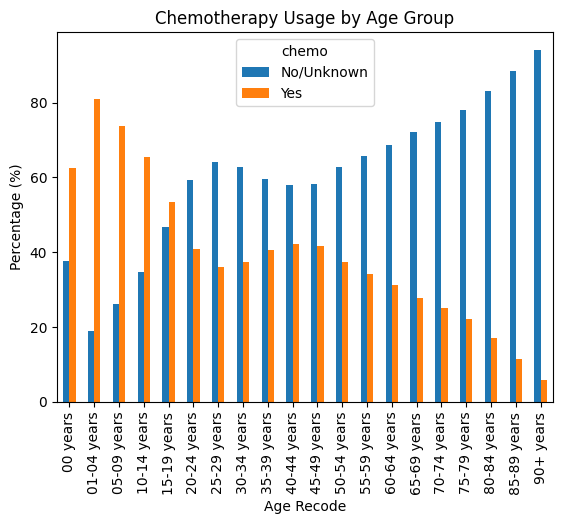

In [28]:
# Chemotheray by Age Group
chemo_by_age = pd.crosstab(SeerData_EDA_clean['age_recode'], SeerData_EDA_clean['chemo'], normalize='index')*100

print(chemo_by_age.round(2))

plt.figure(figsize=(10, 6))
chemo_by_age.plot(kind='bar', stacked=False)
plt.title('Chemotherapy Usage by Age Group')
plt.xlabel('Age Recode')
plt.ylabel('Percentage (%)')
plt.show()

chemo                                               No/Unknown    Yes
race_cat                                                             
Black                                                    67.52  32.48
Other (American Indian/AK Native, Asian/Pacific...       66.01  33.99
White                                                    71.75  28.25
radiation                                           Beam radiation  \
race_cat                                                             
Black                                                        26.38   
Other (American Indian/AK Native, Asian/Pacific...           27.54   
White                                                        24.87   

radiation                                           Combination of beam with implants or isotopes  \
race_cat                                                                                            
Black                                                                                        2.29

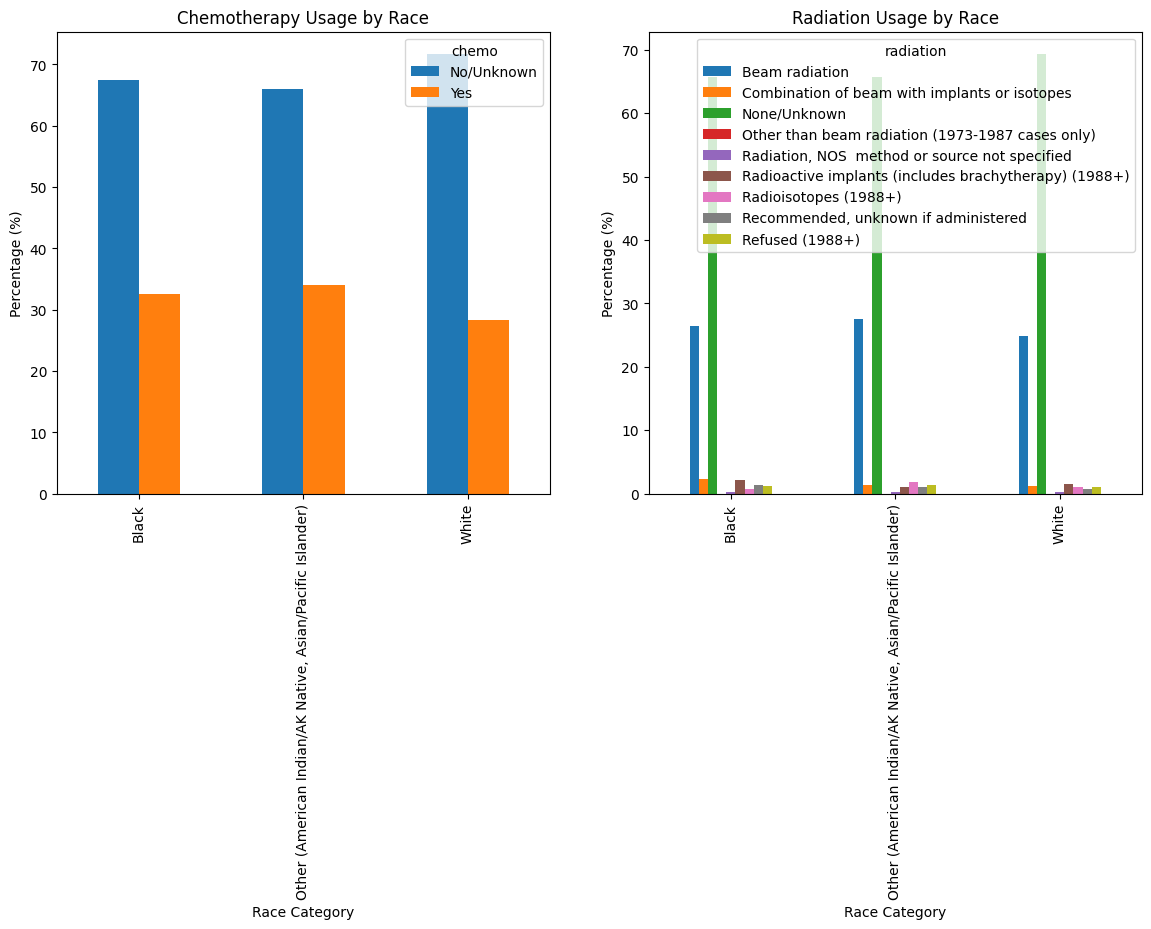

In [29]:
# Treatment by Race

# Chemo
chemo_by_race = pd.crosstab(SeerData_EDA_clean['race_cat'], SeerData_EDA_clean['chemo'], normalize='index')*100
print(chemo_by_race.round(2))


# Radiation
radiation_by_race = pd.crosstab(SeerData_EDA_clean['race_cat'], SeerData_EDA_clean['radiation'], normalize='index')*100
print(radiation_by_race.round(2))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
chemo_by_race.plot(kind='bar', stacked=False, ax=axes[0])
axes[0].set_title('Chemotherapy Usage by Race')
axes[0].set_xlabel('Race Category')
axes[0].set_ylabel('Percentage (%)')
radiation_by_race.plot(kind='bar', stacked=False, ax=axes[1])
axes[1].set_title('Radiation Usage by Race')
axes[1].set_xlabel('Race Category')
axes[1].set_ylabel('Percentage (%)')

plt.show()

            survival_months  vital_status
chemo                                    
No/Unknown            94.55         41.66
Yes                   72.76         36.98


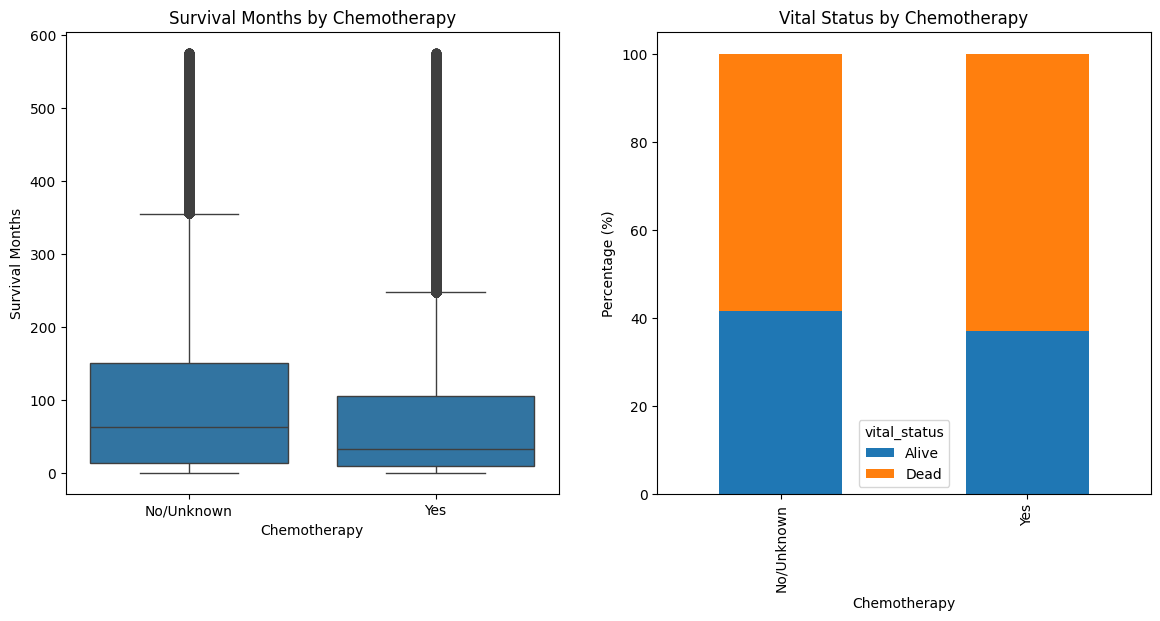

In [32]:
# Survival by Chemo
survival_by_chemo = SeerData_EDA_clean.groupby('chemo').agg({
    'survival_months' : lambda x: pd.to_numeric(x, errors='coerce').mean(),
    'vital_status' : lambda x: (x == 'Alive').mean() * 100
}).round(2)

print(survival_by_chemo)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(x=SeerData_EDA_clean['chemo'], y=pd.to_numeric(SeerData_EDA_clean['survival_months'], errors='coerce'), ax=axes[0])
axes[0].set_title('Survival Months by Chemotherapy')
axes[0].set_xlabel('Chemotherapy')
axes[0].set_ylabel('Survival Months')

vital_by_chemo = pd.crosstab(SeerData_EDA_clean['chemo'], SeerData_EDA_clean['vital_status'], normalize='index')*100
vital_by_chemo.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Vital Status by Chemotherapy')
axes[1].set_xlabel('Chemotherapy')
axes[1].set_ylabel('Percentage (%)')
plt.show()